<a href="https://colab.research.google.com/github/Caceres-A01706972/FruitsVegetables/blob/main/FruitsVegetables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Clasificador Fruits and Vegetables**

### ***Objetivo:***

Desarrollar un clasificador de frutas y vegetales utilizando técnicas de aprendizaje automático.

Lo principal es clasificar imágenes estáticas de frutas y vegetales. Pero en futuras versiones se planea extender esta capacidad para clasificar en tiempo real utilizando la cámara, permitiendo llevar un registro de la cantidad de cada producto mostrado.

Esta funcionalidad está diseñada para facilitar el conteo y seguimiento de productos en un entorno de supermercado.

### ***Drive con el Dataset:***
[Dataset de Fruitas y Vegetales](https://drive.google.com/drive/folders/1Jkadebp3GhvkF-c1rBmxgevV6G_3diNX?usp=sharing)

### ***Nombre y Matricula:***

Ricardo Andrés Cáceres Villibord A01706972

## Conectando Google Drive y Configurango el directorio

In [1]:
from google.colab import drive
drive.mount('/content/drive')
# Aqui dse debe de sustituir el path en donde fue guardada la carpeta del Dataset
%cd "/content/drive/MyDrive/IA_8vo/Proyecto IA"
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/IA_8vo/Proyecto IA
Dataset  FruitsVegetables.ipynb


## Importando librerias necesarias

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image

## Directorios de Train, Test y Validation

In [3]:
base_dir = 'Dataset'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
validation_dir = os.path.join(base_dir, 'validation')

## Para sacar las rutas de las imagenes y sus categorias

In [4]:
image_paths = []
categories = []

# Recorrer todas las carpetas (categorías) y añadir las imagenes a la lista
for category in os.listdir(train_dir):
    category_path = os.path.join(train_dir, category)
    if os.path.isdir(category_path):
        for img_name in os.listdir(category_path):
            if img_name.endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(category_path, img_name))
                categories.append(category)

# Ponerlo en un Dataframe para facil visualizacion
df = pd.DataFrame({
    'image_path': image_paths,
    'category': categories
})

df.head()

,image_path,category
0,Dataset/train/banana/Image_1.jpg,banana
1,Dataset/train/banana/Image_31.jpg,banana
2,Dataset/train/banana/Image_43.png,banana
3,Dataset/train/banana/Image_40.jpg,banana
4,Dataset/train/banana/Image_25.jpg,banana


## Visualización random de como son las imagenes

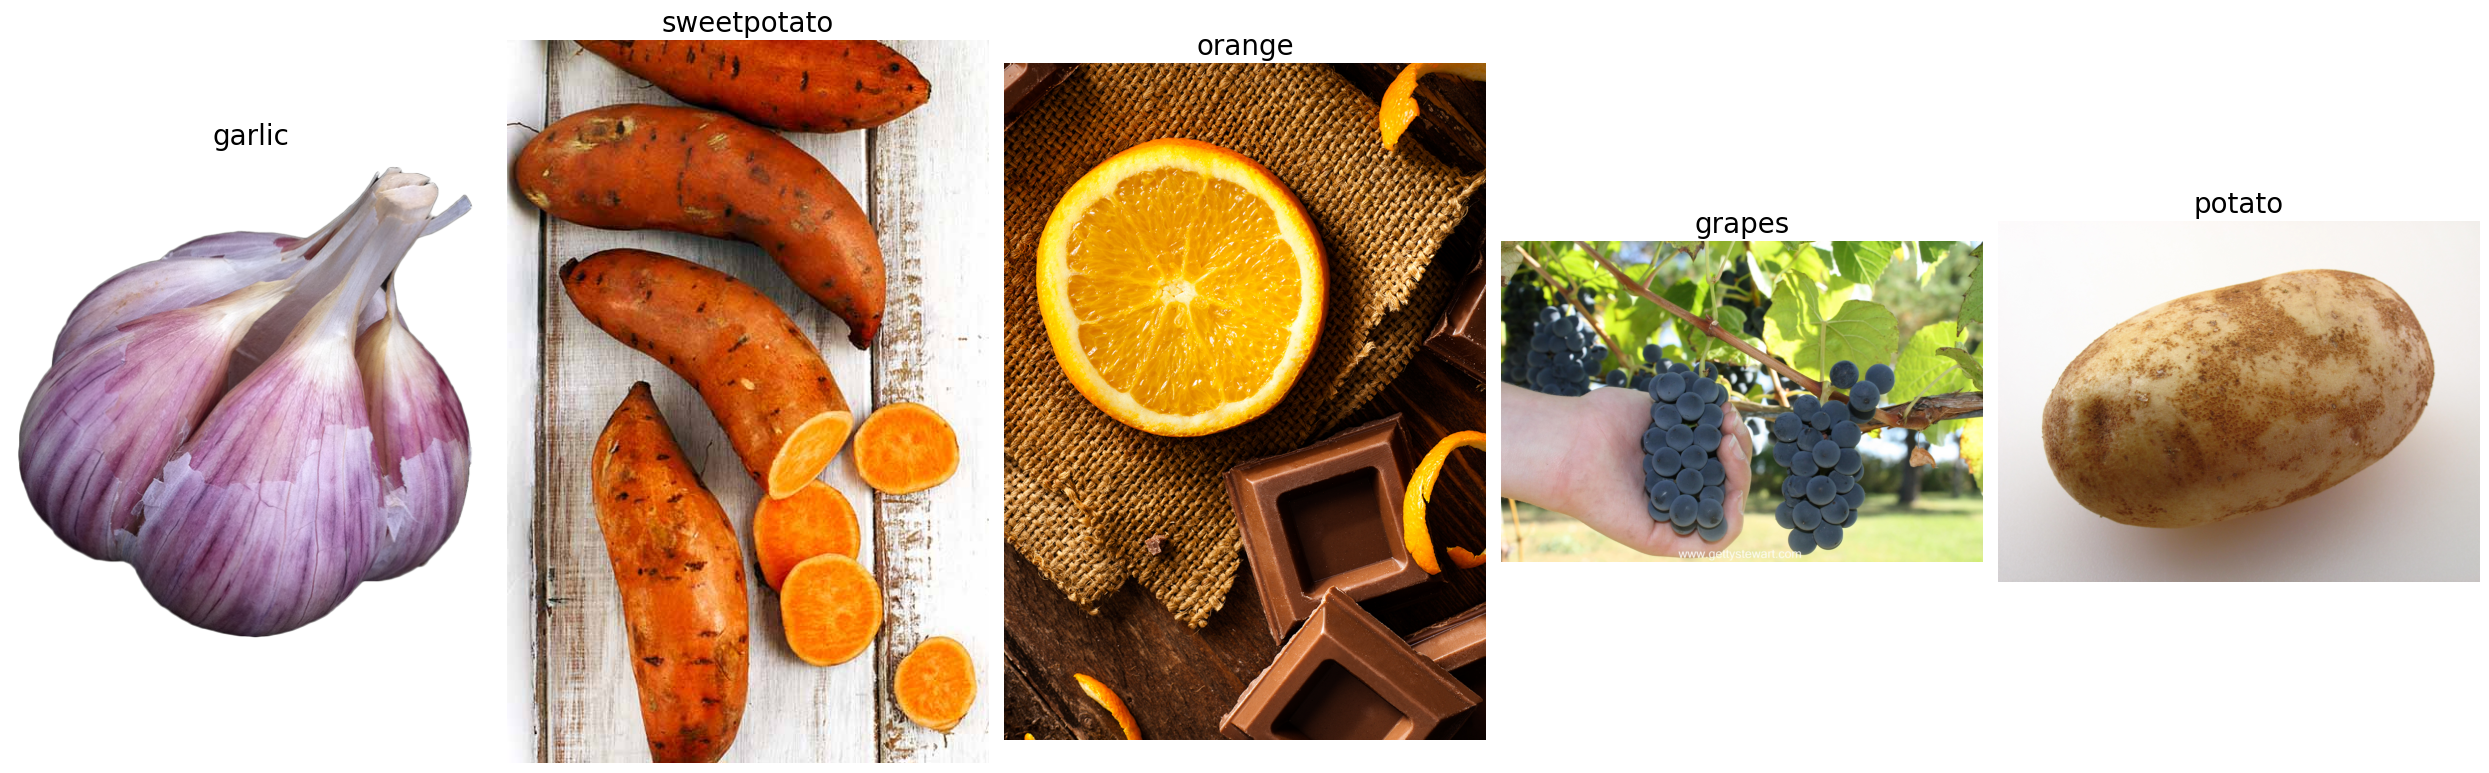

In [5]:
# Seleccionar 5 imágenes aleatorias
random_indices = random.sample(range(len(image_paths)), 5)
random_images = [image_paths[i] for i in random_indices]
random_categories = [categories[i] for i in random_indices]

# Mostrar 5 random images con su label
plt.figure(figsize=(25, 10))
for i in range(5):
    img = Image.open(random_images[i])
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(random_categories[i], fontsize=20)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Data Augmentation
Esto geenera nuevas imagenes en el ram mientras se entrena. (En cada epoca se va a usar una version modificada de la imagen)

In [6]:
# Se define que transformaciones se le van a aplicar
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 100,
    zoom_range = 0.3,
    horizontal_flip = True,
)

# Se define el generador de datos para el conjunto de validación (solo normalización)
validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Se define el generador de datos para el conjunto de prueba (solo normalización)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

Se normaliza las imagenes de test y se generan con el mismo tamaño y el one-hot encoding

In [20]:
# Crear el generador de datos para el conjunto train
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150,150),
    batch_size = 32,
    color_mode = 'rgb',
    class_mode = 'categorical' # Hace one-hot encoding para las categorias (0,0,1,0,0,0.....)
)

# Crear el generador de datos para el conjunto de validación
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,          # Directorio de datos de validación
    target_size=(150, 150),  # Redimensionar las imágenes a 64x64 píxeles
    batch_size=32,            # Número de imágenes por lote
    color_mode = 'rgb',
    class_mode='categorical' # Clasificación categórica
)

# Crear el generador de datos para el conjunto de prueba
test_generator = test_datagen.flow_from_directory(
    test_dir,                # Directorio de datos de prueba
    target_size=(150, 150),  # Redimensionar las imágenes a 150x150 píxeles
    batch_size=32,           # Número de imágenes por lote
    color_mode = 'rgb',
    class_mode='categorical' # Clasificación categórica
)

Found 3115 images belonging to 36 classes.
Found 351 images belonging to 36 classes.
Found 359 images belonging to 36 classes.


## Visualización de Imagenes Aumentadas

In [21]:
# Visualizar algunas imágenes aumentadas del conjunto de entrenamiento
augmented_images = [train_generator[0][0][i] for i in range(5)]

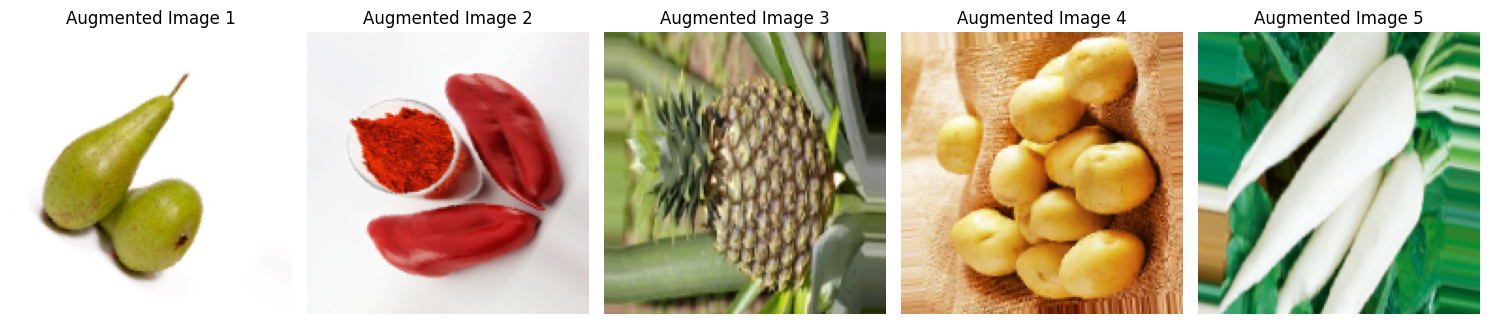

In [22]:
# Mostrar las imágenes aumentadas
plt.figure(figsize=(15, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(augmented_images[i])
    plt.title(f'Augmented Image {i+1}', fontsize=12)
    plt.axis('off')
plt.tight_layout()
plt.show()

## Siguientes pasos



*   Generación del modelo de entrenamiento
*   Entrenamiento
*   Evaluación de modelo







In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [24]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)), # Primera capa convolucional
    MaxPooling2D((2, 2)),  # Primera capa de pooling
    Conv2D(64, (3, 3), activation='relu'),  # Segunda capa convolucional
    MaxPooling2D((2, 2)),  # Segunda capa de pooling
    Conv2D(128, (3, 3), activation='relu'), # Tercera capa convolucional
    MaxPooling2D((2, 2)),  # Tercera capa de pooling
    Flatten(),  # Aplanar la salida de la última capa de pooling
    Dense(512, activation='relu'),  # Capa densa con 512 neuronas
    Dropout(0.5),  # Regularización con dropout
    Dense(len(train_generator.class_indices), activation='softmax')  # Capa de salida
])

In [25]:
# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 17, 17, 128)      

In [27]:
# Entrenar el modelo y guardar el historial del entrenamiento
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/30
 9/97 [=>............................] - ETA: 4:29 - loss: 4.0207 - accuracy: 0.0417

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


97/97 [==============================] - 445s 5s/step - loss: 3.4358 - accuracy: 0.0704 - val_loss: 2.8538 - val_accuracy: 0.2062
Epoch 2/30
97/97 [==============================] - 285s 3s/step - loss: 2.8858 - accuracy: 0.1534 - val_loss: 2.1805 - val_accuracy: 0.3156
Epoch 3/30
97/97 [==============================] - 276s 3s/step - loss: 2.5711 - accuracy: 0.2160 - val_loss: 2.0968 - val_accuracy: 0.3750
Epoch 4/30
97/97 [==============================] - 286s 3s/step - loss: 2.4433 - accuracy: 0.2592 - val_loss: 1.8333 - val_accuracy: 0.4437
Epoch 5/30
97/97 [==============================] - 276s 3s/step - loss: 2.3250 - accuracy: 0.2861 - val_loss: 1.6426 - val_accuracy: 0.4875
Epoch 6/30
97/97 [==============================] - 282s 3s/step - loss: 2.2755 - accuracy: 0.3188 - val_loss: 1.6916 - val_accuracy: 0.5188
Epoch 7/30
97/97 [==============================] - 271s 3s/step - loss: 2.2159 - accuracy: 0.3127 - val_loss: 1.6186 - val_accuracy: 0.5531
Epoch 8/30
97/97 [======

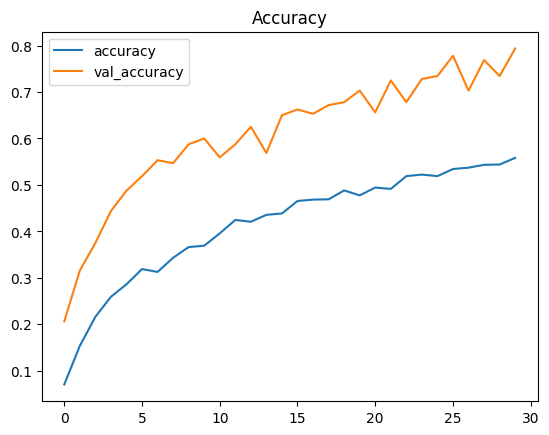

In [28]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

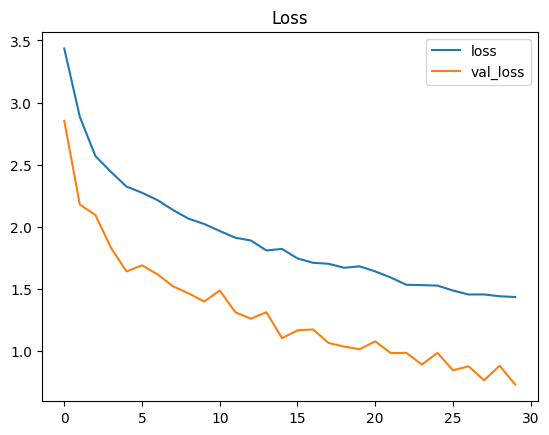

In [29]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [30]:
# Predict the label of the test_images
pred = model.predict(test_generator)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_generator.classes]

12/12 [==============================] - 121s 11s/step


In [31]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 2.79%


In [34]:
# Guardar el modelo completo en el sistema de archivos temporal
model.save('fruit_vegetable_classifier_Simple.h5')

# Guardar el modelo en Google Drive
model_save_path = '/content/drive/MyDrive/IA_8vo/Proyecto IA/fruit_vegetable_classifier_Simple.h5'
model.save(model_save_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
